In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from typing import Sequence
import tarfile
import io
import torch
import numpy as np
from omegaconf import DictConfig
from tqdm import tqdm
from datasets.video import OpticalFlowVideoDataset
import torch
from torchvision.utils import flow_to_image
from unittest.mock import MagicMock
import tqdm 
from algorithms.diffusion_forcing import DiffusionForcingFlow

import mediapy as media
from einops import rearrange

/home/iyu/miniconda3/envs/diff-force/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


""

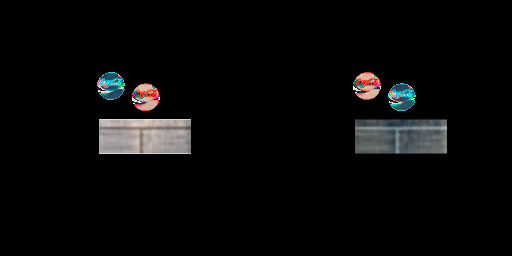

In [2]:
data = np.load("/home/iyu/scene-jacobian-discovery/diff-force/diffusion-forcing/data/pusher_rotate_rod/training/down.pkl.npz")
data_right = np.load("/home/iyu/scene-jacobian-discovery/diff-force/diffusion-forcing/data/pusher_down_right/training/right.pkl.npz")

vid = data["birdview_rgb"]
vid_right = data_right["birdview_rgb"]

first_down = vid[1]
first_right = vid_right[1]

diff = first_down - first_right
diff1 = first_right - first_down
media.show_image(np.concatenate([diff, diff1], axis=1))

media.show_video(data["birdview_rgb"], fps=24)

In [3]:
from torchvision.utils import flow_to_image
H, W = data["flow"].shape[-2], data["flow"].shape[-1]

flows = flow_to_image(torch.from_numpy(data["flow"]))
#flows = torch.nn.functional.interpolate(flows, (H, W))
flows = rearrange(flows, "... c h w -> ... h w c")
flows = flows.numpy()

flows_right = flow_to_image(torch.from_numpy(data_right["flow"]))
#flows = torch.nn.functional.interpolate(flows, (H, W))
flows_right = rearrange(flows_right, "... c h w -> ... h w c")
flows_right = flows_right.numpy()

# for i in range(flows.shape[0]):
#     img = np.concatenate([vid[i], flows[i]], axis=1)
#     print("frame", i)
#     media.show_image(img)
# media.show_video(np.concatenate([flows, flows_right], axis=2), fps=30)
#media.show_image(flows)
flows_cat = np.concatenate([flows, flows_right], axis=1)
rgb_cat = np.concatenate([vid, vid_right], axis=1)

#media.show_video(np.concatenate([rgb_cat, flows_cat], axis=2), fps=24)
media.show_video(np.concatenate([vid, flows], axis=2), fps=24)

4900
dataset item shapes torch.Size([1, 2, 256, 256]) torch.Size([1, 3, 256, 256]) (1,)
torch.Size([256, 256, 3])
max min tensor(1.) tensor(0.)
max min tensor(0.0256) tensor(-0.0074)
max min 1.0 0.0


""

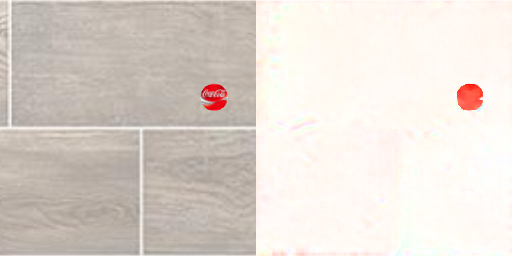

In [25]:
cfg = MagicMock()
cfg.resolution = 256
cfg.external_cond_dim = 0
cfg.n_frames = 1
cfg.frame_skip = 1
cfg.save_dir = "/home/iyu/scene-jacobian-discovery/diff-force/diffusion-forcing/data/rod_flow"
cfg.validation_multiplier = 1
cfg.frame_stack = 1

dataset = OpticalFlowVideoDataset(cfg, "training")
print(len(dataset))

flow, vid, term = dataset[49]
print("dataset item shapes", flow.shape, vid.shape, term.shape)

data_mean = torch.tensor(0)
data_std = torch.tensor(1)

def _normalize_x(xs: torch.Tensor) -> torch.Tensor:
    shape = [1] * (xs.ndim - data_mean.ndim) + list(data_mean.shape)
    mean = data_mean.reshape(shape)
    std = data_std.reshape(shape)
    return (xs - mean) / std

def _unnormalize_x(xs: torch.Tensor) -> torch.Tensor:
    shape = [1] * (xs.ndim - data_mean.ndim) + list(data_mean.shape)
    mean = data_mean.reshape(shape)
    std = data_std.reshape(shape)
    return xs * std + mean

def _unstack_and_unnormalize(xs: torch.Tensor) -> torch.Tensor:
    xs = rearrange(xs, "t b (fs c) ... -> (t fs) b c ...", fs=1)
    return _unnormalize_x(xs)

vid_np = rearrange(vid[0], "... c h w -> ... h w c")
print(vid_np.shape)

#flow = flow * 16
print("max min", vid_np.max(), vid_np.min())
print("max min", flow.max(), flow.min())

H, W = 256, 256
gt_img = flow_to_image(flow)
# gt_img = torch.nn.functional.interpolate(gt_img, (H, W))

gt_img = rearrange(gt_img, "t c h w -> t h w c")
gt_img = gt_img[0].numpy() / 255

print("max min", gt_img.max(), gt_img.min())
combined_img = np.concatenate([vid_np, gt_img], axis=1)
media.show_image(combined_img)

In [5]:
# calculate mean and standard deviation of the dataset
right = np.load("/home/iyu/scene-jacobian-discovery/diff-force/diffusion-forcing/data/rod_flow/training/right.pkl.npz")
down = np.load("/home/iyu/scene-jacobian-discovery/diff-force/diffusion-forcing/data/pusher_down/training/down.pkl.npz")

right_flow = right["flow"]
down_flow = down["flow"]

#right_flow = np.concatenate([right_flow, down_flow], axis=0)

print("right flow shape", right_flow.shape)

ax_1_flow = right_flow[:, 0:1, :, :]
ax_2_flow = right_flow[:, 1:2, :, :]

# calculate norms along the first axis
flow_norm = np.linalg.norm(ax_1_flow, axis=1)
print("ax 1 norm shape", flow_norm.shape)

right_mean_ax_1 = ax_1_flow.mean()
right_mean_ax_2 = ax_2_flow.mean()

right_std_ax_1 = ax_1_flow.std()
right_std_ax_2 = ax_2_flow.std()

print("right mean", [right_mean_ax_1, right_mean_ax_2])
print("right std", [right_std_ax_1, right_std_ax_2])
print("right ax 1 min", ax_1_flow.min())
print("right ax 1 max", ax_1_flow.max())
print("right ax 2 min", ax_2_flow.min())
print("right ax 2 max", ax_2_flow.max())
print("flow norm min", flow_norm.min())
print("flow norm max", flow_norm.max())

right flow shape (49, 2, 256, 256)
ax 1 norm shape (49, 256, 256)
right mean [0.04690941, 0.013209569]
right std [0.6192929, 0.019750817]
right ax 1 min -0.34880227
right ax 1 max 16.064114
right ax 2 min -2.4485154
right ax 2 max 1.3629317
flow norm min 2.514571e-08
flow norm max 16.064114
